In [1]:
import numpy as np
import pandas as pd

# Projet : Complétion de Matrices par Méthode d'Optimisation Alternée

### Introduction

Ce projet vise à étudier et à reproduire les expériences proposées dans le blog (https://ee227c.github.io/code/lecture19.html) concernant la **complétion de matrices**. La complétion de matrices consiste à reconstruire une matrice partiellement observée à partir de quelques entrées observées.

Nous allons utiliser une approche basée sur la **méthode d'optimisation alternée** pour compléter les matrices. L'objectif est de tester l'influence du choix des divers paramètres, comme le rang de la matrice, le taux d'observations manquantes et le nombre d'itérations.

### Problème et Méthodologie

Soit une matrice \( M \in \mathbb{R}^{n \times m} \) partiellement observée. Nous cherchons à la compléter en supposant qu'elle peut être factorisée comme le produit de deux matrices de rang faible, \( U \in \mathbb{R}^{n \times k} \) et \( V \in \mathbb{R}^{m \times k} \), où \( k \) est le rang de la matrice approximée.

La méthode d'optimisation alternée consiste à fixer successivement une des deux matrices (par exemple \( U \)) et à optimiser l'autre (par exemple \( V \)), et vice versa, jusqu'à convergence.

Les étapes de l'algorithme sont les suivantes :
1. Initialiser les matrices \( U \) et \( V \) aléatoirement.
2. Fixer \( U \), puis optimiser \( V \).
3. Fixer \( V \), puis optimiser \( U \).
4. Répéter jusqu'à convergence.

Nous commencerons par générer un jeu de données arbitraire.

## Génération des Données

Nous allons générer une matrice de taille \( n \\times m \) de rang faible et masquer aléatoirement certaines de ses entrées pour créer un problème de complétion de matrices.


In [2]:
# Génération d'une matrice arbitraire de rang faible

np.random.seed(42)  # Pour rendre l'expérience reproductible

# Dimensions de la matrice
n, m = 50, 40  # Taille de la matrice
k = 5  # Rang de la matrice

# Génération des matrices U et V de rang k
U = np.random.randn(n, k)
V = np.random.randn(m, k)

# Matrice complète de rang faible
M = np.dot(U, V.T)

# Masquer aléatoirement 30% des entrées pour simuler des observations manquantes
mask = np.random.rand(n, m) > 0.3
M_observed = np.where(mask, M, np.nan)

# Afficher les premières valeurs de la matrice observée avec des valeurs manquantes
pd.DataFrame(M_observed).head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,2.549531,-0.379477,-4.052554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.528769,0.427531,1.383466,1.268963,NaN,NaN,0.260776,-3.663547,-0.974054,-0.861417
1,NaN,1.782933,-2.020545,NaN,NaN,-0.496291,NaN,0.199080,NaN,1.778721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.265001,NaN,-0.632594
2,1.315715,-2.722196,NaN,0.088354,1.955697,0.078999,-1.288243,NaN,NaN,-2.664800,...,NaN,-0.943392,-3.194962,-2.720357,NaN,0.989762,-2.531414,2.228099,1.757616,2.101738
3,1.654531,-2.730289,0.849803,-1.186237,NaN,-0.169268,-2.124579,NaN,NaN,-2.052286,...,NaN,-0.149419,-1.372641,-2.280027,-4.808510,1.946129,NaN,-0.499706,1.090701,0.919329
4,NaN,-2.097572,0.032996,-1.738167,3.034867,0.702115,NaN,-2.848433,NaN,-2.698802,...,NaN,0.692865,-0.807975,-3.156378,0.871631,1.719557,NaN,2.104829,1.267780,2.144016


## Complétion de la Matrice par Méthode d'Optimisation Alternée

Nous allons maintenant implémenter la méthode d'optimisation alternée pour compléter la matrice à partir des observations partielles.
L'algorithme alterne entre la mise à jour de \( U \) et \( V \) en minimisant les erreurs quadratiques des entrées observées.


In [3]:
# Fonction pour compléter la matrice en utilisant l'optimisation alternée
def matrix_completion_als(M_observed, k, max_iter=100, tol=1e-4):
    n, m = M_observed.shape

    # Initialisation des matrices U et V
    U = np.random.randn(n, k)
    V = np.random.randn(m, k)

    # Liste pour stocker l'erreur de reconstruction
    errors = []

    # Itération de l'algorithme
    for iteration in range(max_iter):
        # Mise à jour de U en fixant V
        for i in range(n):
            observed_indices = ~np.isnan(M_observed[i, :])
            V_observed = V[observed_indices, :]
            M_observed_i = M_observed[i, observed_indices]
            U[i, :] = np.linalg.solve(V_observed.T.dot(V_observed), V_observed.T.dot(M_observed_i))

        # Mise à jour de V en fixant U
        for j in range(m):
            observed_indices = ~np.isnan(M_observed[:, j])
            U_observed = U[observed_indices, :]
            M_observed_j = M_observed[observed_indices, j]
            V[j, :] = np.linalg.solve(U_observed.T.dot(U_observed), U_observed.T.dot(M_observed_j))

        # Calcul de l'erreur de reconstruction
        M_hat = np.dot(U, V.T)
        error = np.nansum((M_observed - M_hat) ** 2) / np.sum(~np.isnan(M_observed))
        errors.append(error)

        # Vérification de la convergence
        if iteration > 0 and abs(errors[-1] - errors[-2]) < tol:
            break

    return U, V, errors

# Appliquer l'algorithme sur notre matrice partiellement observée
U_hat, V_hat, errors = matrix_completion_als(M_observed, k)

# Matrice complétée
M_completed = np.dot(U_hat, V_hat.T)

# Afficher les premières valeurs de la matrice complétée
pd.DataFrame(M_completed).head()


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,2.550674,-0.380380,-4.054822,-2.474678,1.914047,0.009558,-1.395146,0.009234,0.793495,0.820189,...,-0.528062,0.427273,1.385185,1.269883,1.944070,3.285170,0.261862,-3.664202,-0.973668,-0.861466
1,2.058763,1.782439,-2.021782,2.045515,-2.246424,-0.495275,3.975144,0.196399,-1.385318,1.777750,...,-0.839585,-1.714902,-3.532340,2.194693,1.997405,-2.765102,-2.668617,2.263408,-2.393258,-0.632502
2,1.313223,-2.722109,2.064862,0.086997,1.957511,0.080207,-1.287052,1.640010,-2.057893,-2.664642,...,1.701276,-0.941630,-3.194431,-2.721419,-4.792690,0.991000,-2.534529,2.226485,1.757172,2.101672
3,1.652386,-2.731004,0.849233,-1.185273,2.386275,-0.168794,-2.125009,2.051147,-0.845582,-2.053463,...,2.097095,-0.149119,-1.374809,-2.281898,-4.805881,1.945837,-0.129781,-0.499044,1.091414,0.919957
4,-2.550411,-2.098753,0.033232,-1.738393,3.035567,0.701313,0.726633,-2.845531,-1.639393,-2.698546,...,-2.020129,0.691302,-0.810506,-3.156142,0.871248,1.718825,-3.133265,2.104409,1.266752,2.143349


## Analyse des Résultats

L'algorithme a permis de compléter la matrice à partir des observations partielles. Nous allons maintenant analyser l'erreur de reconstruction au cours des itérations.


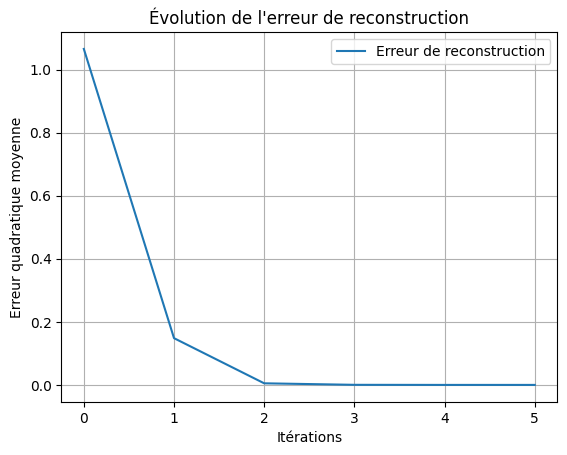

In [4]:
import matplotlib.pyplot as plt

# Tracé de l'erreur de reconstruction au cours des itérations
plt.plot(errors, label='Erreur de reconstruction')
plt.xlabel('Itérations')
plt.ylabel('Erreur quadratique moyenne')
plt.title('Évolution de l\'erreur de reconstruction')
plt.legend()
plt.grid(True)
plt.show()

## Test avec d'autres paramètres

Nous allons tester l'algorithme avec différents paramètres, comme le rang de la matrice et le taux d'observations manquantes.


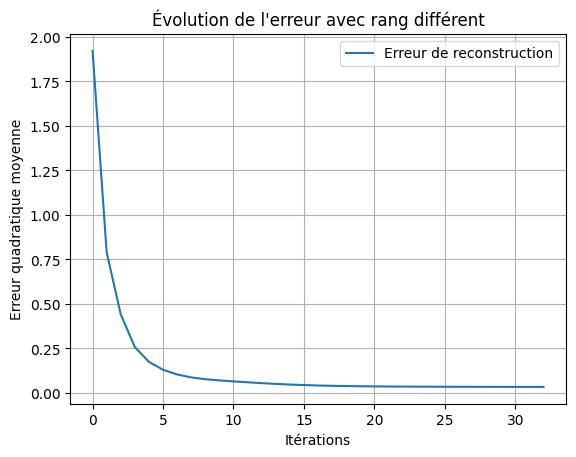

In [5]:
# Répéter l'expérience avec un rang différent ou un pourcentage de valeurs manquantes différent
n, m = 50, 40  # Taille de la matrice
k = 8  # Changer le rang de la matrice

# Générer une nouvelle matrice de rang faible et masquer 50% des entrées
U = np.random.randn(n, k)
V = np.random.randn(m, k)
M = np.dot(U, V.T)
mask = np.random.rand(n, m) > 0.5
M_observed = np.where(mask, M, np.nan)

# Compléter la matrice avec la méthode d'optimisation alternée
U_hat, V_hat, errors = matrix_completion_als(M_observed, k)
M_completed = np.dot(U_hat, V_hat.T)

# Afficher les résultats
pd.DataFrame(M_completed).head()

# Tracé de l'erreur de reconstruction
plt.plot(errors, label='Erreur de reconstruction')
plt.xlabel('Itérations')
plt.ylabel('Erreur quadratique moyenne')
plt.title('Évolution de l\'erreur avec rang différent')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion et Ouvertures

Nous avons réussi à implémenter et tester la complétion de matrices par méthode d'optimisation alternée. Nous avons également exploré l'influence de différents paramètres sur les résultats.

### Ouvertures possibles :
- Tester l'algorithme sur des jeux de données réels.
- Explorer l'influence d'autres facteurs, comme le taux de convergence ou l'initialisation des matrices.
- Améliorer l'algorithme pour mieux gérer les observations manquantes.
